# Graph-Based Feature Setup <a name="head"></a>

When exact geometries are unknown it may be beneficial to use features "binned" into neighbor shells. This avoids adding noise from changes in the geometry when a optimization is performed. For this, we use some graph-based features, similar to others aside from instead of using explicit distances, features are based on the neighbor shell.

## Table of Contents
[(Back to top)](#head)

-   [Requirements](#requirements)
-   [Setup](#setup)
-   [Neighbor Shells](#neighbor-shells)
-   [Efficiency](#efficiency)
-   [Gaussian Process Regression](#gaussian-process-regression)
-   [Conclusions](#conclusions)

## Requirements <a name="requirements"></a>
[(Back to top)](#head)

-   [CatLearn](https://github.com/SUNCAT-Center/CatLearn)
-   [ASE](https://wiki.fysik.dtu.dk/ase/)
-   [numpy](http://www.numpy.org/)
-   [matplotlib](https://matplotlib.org/index.html)
-   [seaborn](http://seaborn.pydata.org/index.html)

## Setup <a name="setup"></a>
[(Back to top)](#head)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from ase.ga.data import DataConnection

from catlearn.utilities.neighborlist import ase_neighborlist, catlearn_neighborlist
from catlearn.featurize.setup import FeatureGenerator
from catlearn.api.ase_data_setup import get_unique, get_train
from catlearn.regression import GaussianProcess
from catlearn.regression.cost_function import get_error

## Neighbor Shells <a name="neighbor-shells"></a>
[(Back to top)](#head)

When using the `catlearn_neighborlist` function, it is possible to retrieve the full list of neighbor shells. In the following, we will import some atoms objects for 147-atom icosahedral nanoparticles, then iterate over neighbor shells until all neighbor pairs are assigned. To start with we import the relevant data.

In [2]:
# Connect ase atoms database.
gadb = DataConnection('../../data/gadb.db')

# Get all relaxed candidates from the db file.
all_cand = gadb.get_all_relaxed_candidates(use_extinct=False)

In this case, it is known that there are 5 shells through which we can iterate until all neighbor pairs are accounted for. Some heatmaps are plotted to show the neighbor interactions as new shells are added.

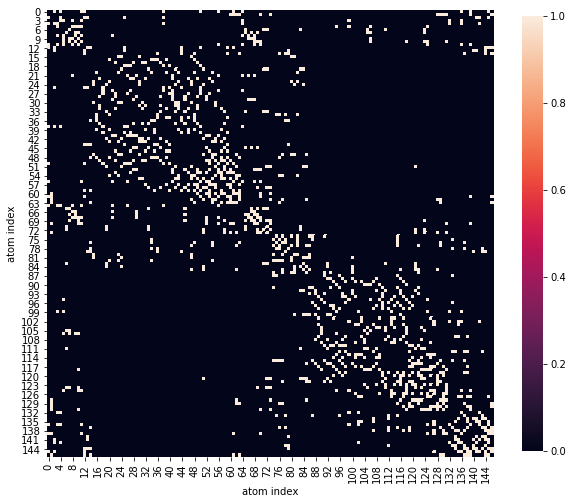

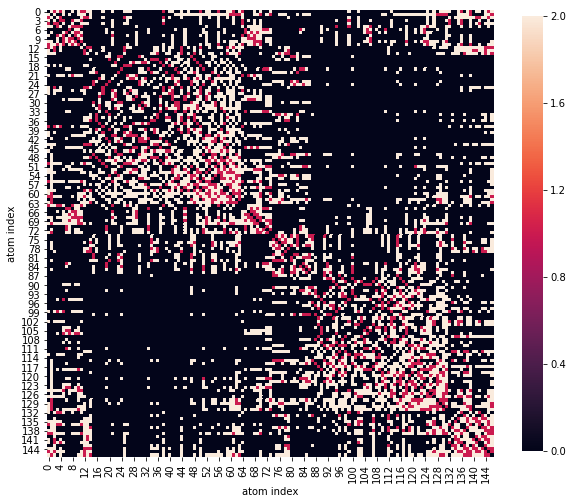

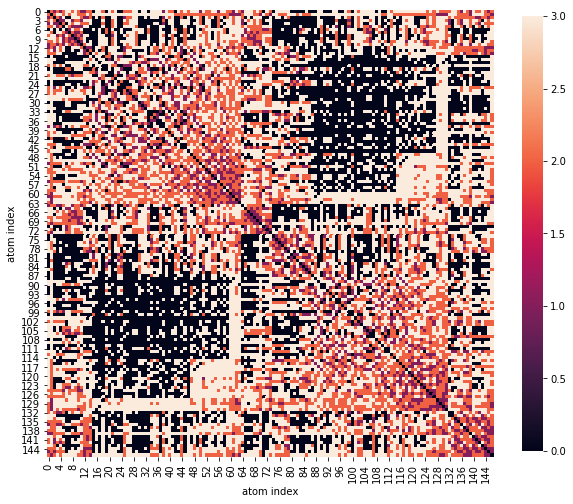

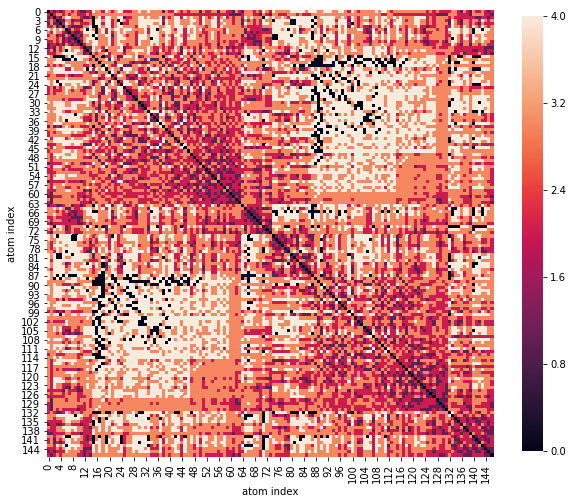

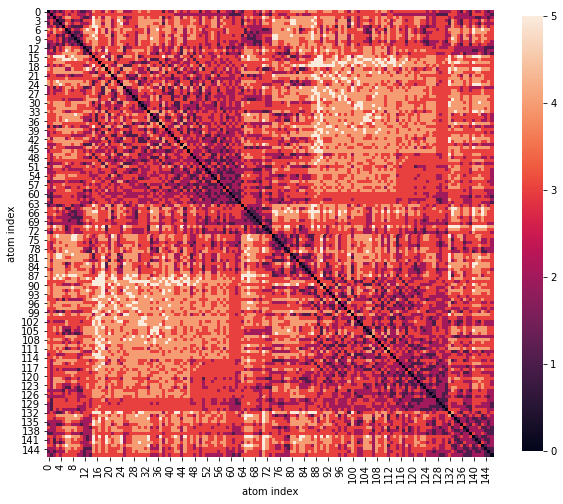

In [3]:
for i in range(5):
    nl = catlearn_neighborlist(all_cand[0], max_neighbor=i+1)

    plt.figure(figsize=(10,10))
    sns.heatmap(nl, square=True, cbar_kws={"shrink": .8})
    plt.xlabel('atom index')
    plt.ylabel('atom index')

## Efficiency <a name="efficiency"></a>
[(Back to top)](#head)

The code used to calculate the neighbor shells should be relatively efficient. In the following the ASE (3.15.0) neighbor list generation function is used to get the first nearest neighbors.

In [4]:
stime = time.time()
for atoms in all_cand:
    ase_neighborlist(atoms)
print('single neighbor shell: {0:.2f}'.format(time.time() - stime))

single neighbor shell: 15.62


This process takes a relatively long time to generate all ~1000 feature vectors. This time is reduced when calculating all neighbors with the `catlearn_neighborlist` function.

In [5]:
# Get all relaxed candidates from the db file.
all_cand = gadb.get_all_relaxed_candidates(use_extinct=False)

stime = time.time()
for atoms in all_cand:
    catlearn_neighborlist(atoms, max_neighbor='full')
print('all neighbor shells: {0:.2f}'.format(time.time() - stime))

all neighbor shells: 4.84


## Gaussian Processes Regression <a name="gaussian-process-regression"></a>
[(Back to top)](#head)

Next, we make some predictions on the various feature vectors. For this, the data set is separated into a simple training and test set.

In [6]:
testset = get_unique(atoms=all_cand, size=100, key='raw_score')

trainset = get_train(atoms=all_cand, size=500, taken=testset['taken'],
                     key='raw_score')

After this, a basic Gaussian process prediction function is set up.

In [7]:
def predict(train_features, train_targets, test_features, test_targets, n):
    kernel = [{'type': 'gaussian', 'width': 1., 'scaling': 1., 'dimension': 'single'}]
    gp = GaussianProcess(train_fp=train_features, train_target=train_targets,
                         kernel_list=kernel, regularization=1e-2,
                         optimize_hyperparameters=True, scale_data=True)

    pred = gp.predict(test_fp=test_features)

    error = get_error(pred['prediction'],
                      test_targets)['rmse_average']

    print('error for {0} neighbors: {1:.3f}'.format(n, error))
    
    plt.figure(figsize=(10, 10))
    plt.plot(test_targets, pred['prediction'], 'o', c='r', alpha=0.5)
    plt.show()

And then predictions are made taking into account the various number of neighbor shells.

100%|██████████| 100/100 [00:00<00:00, 232.77it/s]


error for 1 neighbors: 0.347


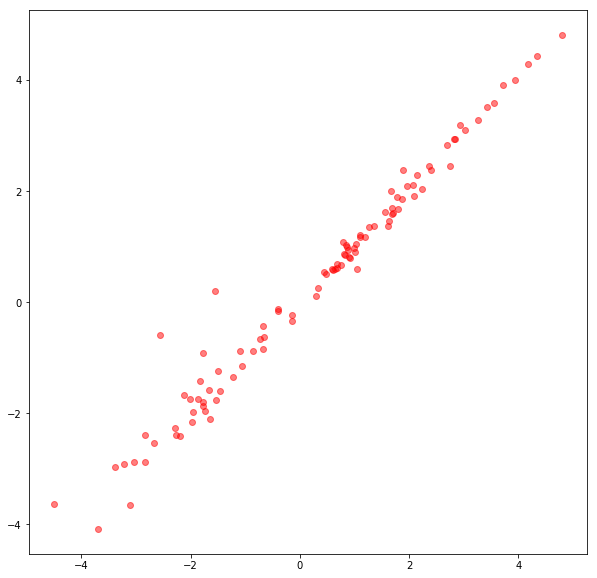

100%|██████████| 100/100 [00:00<00:00, 103.17it/s]


error for 2 neighbors: 0.482


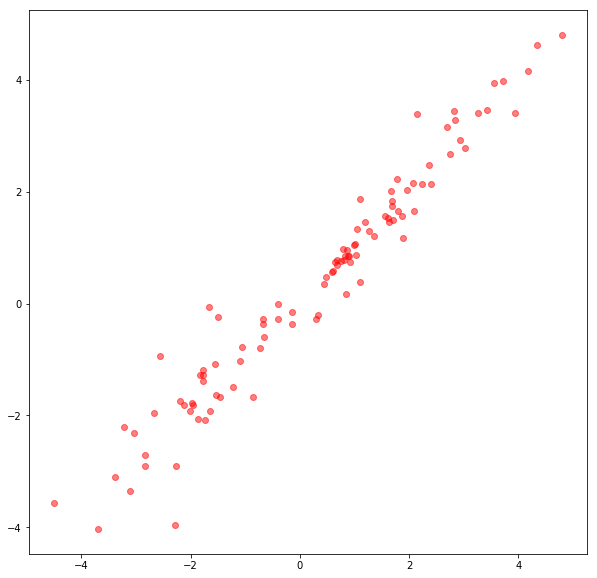

100%|██████████| 100/100 [00:00<00:00, 193.23it/s]


error for 3 neighbors: 0.355


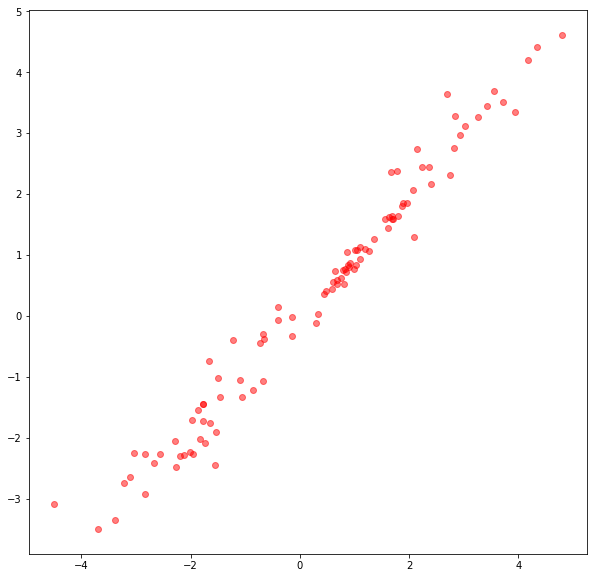

100%|██████████| 100/100 [00:00<00:00, 163.70it/s]


error for 4 neighbors: 0.333


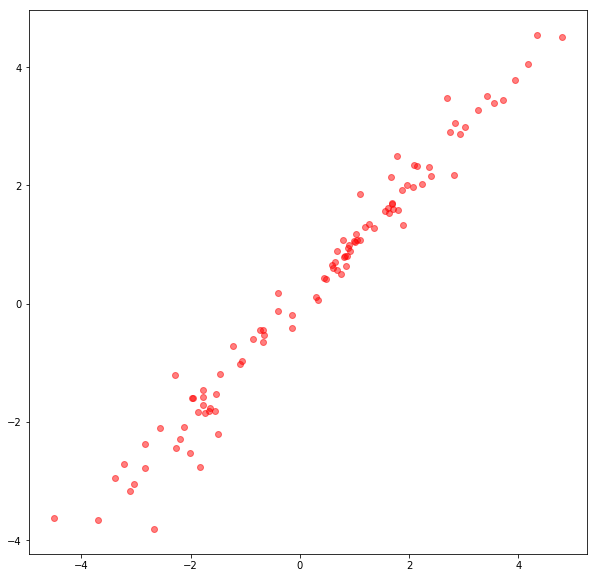

100%|██████████| 100/100 [00:00<00:00, 167.61it/s]


error for 5 neighbors: 0.331


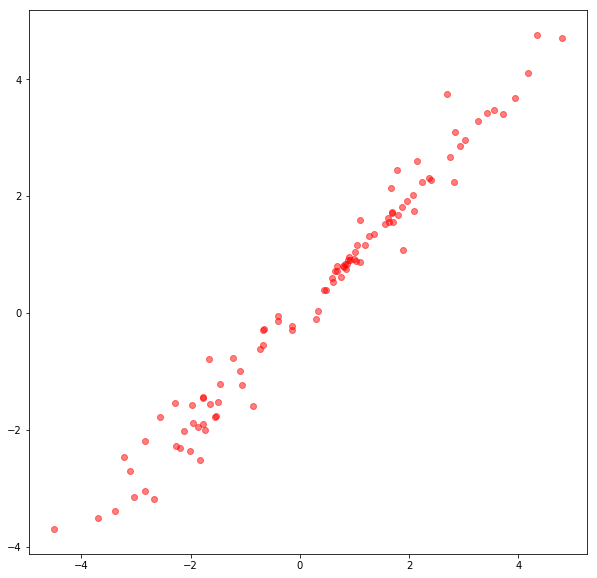

In [8]:
for number in range(5):
    generator = FeatureGenerator(atom_types=[78, 79], element_parameters='atomic_radius',
                             max_neighbors=number+1, nprocs=1)
    train_features = generator.return_vec(trainset['atoms'], [generator.neighbor_sum_vec])
    test_features = generator.return_vec(testset['atoms'], [generator.neighbor_sum_vec])

    predict(train_features, trainset['target'], test_features, testset['target'], number+1)

## Conclusions <a name="conclusions"></a>
[(Back to top)](#head)

The inclusion of additional neighbor shells is beneficial for some of the outliers. In general, it appears to add noise in the case of well-behaved systems.